# Data Preprocessing met MFE (Mel-Frequency Energy)

Dit notebook voert de volledige preprocessing pipeline uit:

1. **Data inlezen** - Leest audio data uit `Data/` folder (CSV formaat)
2. **MFE extractie** - Past Mel-Frequency Energy preprocessing toe
3. **Opslaan** - Slaat verwerkte data op in `processed/` folder
4. **Visualisatie** - Toont vergelijking origineel vs MFE (overlappend)

## Import Libraries

In [69]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt
import joblib

## Setup Paths en Parameters

In [70]:
# Paths
DATA_DIR = Path("Data")
PROCESSED_DIR = Path("processed")
NORMALIZED_DIR = Path("normalized")

# Maak folders aan
PROCESSED_DIR.mkdir(exist_ok=True)
NORMALIZED_DIR.mkdir(exist_ok=True)

# MFE Parameters
SR = 22050  # Sample rate
N_MELS = 128  # Number of mel bands
N_FFT = 2048  # FFT window size
HOP_LENGTH = 512  # Hop length for STFT

print(f"Data directory: {DATA_DIR}")
print(f"Processed directory: {PROCESSED_DIR}")
print(f"Normalized directory: {NORMALIZED_DIR}")
print(f"MFE Parameters: n_mels={N_MELS}, n_fft={N_FFT}, hop_length={HOP_LENGTH}")

Data directory: Data
Processed directory: processed
Normalized directory: normalized
MFE Parameters: n_mels=128, n_fft=2048, hop_length=512


## MFE Feature Extraction Functie

In [71]:
def extract_mfe_features(audio_data, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Extract Mel-Frequency Energy (MFE) features from audio data.
    
    Parameters:
    - audio_data: numpy array of audio samples
    - sr: sample rate
    - n_mels: number of mel bands
    - n_fft: FFT window size
    - hop_length: hop length for STFT
    
    Returns:
    - mfe_features: Mel-Frequency Energy features
    """
    # Compute mel spectrogram (power spectrogram)
    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        power=2.0  # Energy (power=2.0)
    )
    
    # MFE is the mel spectrogram itself (energy in each mel band)
    mfe_features = mel_spec
    
    return mfe_features

In [72]:
def preprocess_signal(signal):
    """
    Preprocess audio signal: DC removal, high-pass filter, alignment, peak normalization
    """
    # DC removal
    signal = signal - np.mean(signal)
    
    # High-pass filter (remove frequencies below 20 Hz)
    nyquist = SR / 2
    cutoff = 20 / nyquist
    b, a = butter(4, cutoff, btype='high')
    signal = filtfilt(b, a, signal)
    
    # Find peak and align
    peak_idx = np.argmax(np.abs(signal))
    if peak_idx > 100:  # Als er genoeg samples zijn voor de peak
        signal = signal[peak_idx-100:]
    
    # Peak normalization
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        signal = signal / max_val
    
    return signal

## Lees en Verwerk Data uit Data Folder

In [73]:
print(f"\n{'='*60}")
print("STAP 1: VERWERKEN VAN RAW DATA NAAR MFE FEATURES")
print(f"{'='*60}")

# Vind alle CSV bestanden in de Data folder (DYNAMISCH)
csv_files = list(DATA_DIR.glob("*.csv"))
print(f"\nGevonden CSV bestanden: {[f.name for f in csv_files]}")

if len(csv_files) == 0:
    print("⚠️  WAARSCHUWING: Geen CSV bestanden gevonden in Data folder!")
else:
    # Verwerk elk CSV bestand
    for csv_file in csv_files:
        print(f"\n{'='*60}")
        print(f"Verwerken: {csv_file.name}")
        print(f"{'='*60}")
        
        # Lees CSV data
        df = pd.read_csv(csv_file)
        print(f"  Originele shape: {df.shape}")
        print(f"  Aantal samples per rij: {df.shape[1]}")
        print(f"  Aantal hits (rijen): {df.shape[0]}")
        
        # Bereken MFE features voor elke hit
        all_mfe_features = []
        
        for idx, row in df.iterrows():
            # Converteer rij naar 1D numpy array (audio samples)
            audio_data = row.values.astype(np.float32)
            
            # Pas MFE preprocessing toe
            mfe_features = extract_mfe_features(audio_data)
            
            # MFE features hebben shape (n_mels, time_frames)
            # Flatten naar 1D voor opslaan in CSV
            mfe_flat = mfe_features.flatten()
            all_mfe_features.append(mfe_flat)
            
            if idx == 0:  # Print info voor eerste hit
                print(f"  MFE features shape per hit: {mfe_features.shape}")
                print(f"  MFE flattened size: {len(mfe_flat)}")
        
        # Converteer naar DataFrame
        mfe_df = pd.DataFrame(all_mfe_features)
        
        # Sla op in processed folder (voeg '_processed' toe aan bestandsnaam)
        output_file = PROCESSED_DIR / f"{csv_file.stem}_processed.csv"
        mfe_df.to_csv(output_file, index=False)
        print(f"  ✓ Opgeslagen: {output_file.name}")
        print(f"  Output shape: {mfe_df.shape}")
    
    print(f"\n{'='*60}")
    print(f"✓ Alle bestanden verwerkt en opgeslagen in {PROCESSED_DIR}/")
    print(f"{'='*60}")


STAP 1: VERWERKEN VAN RAW DATA NAAR MFE FEATURES

Gevonden CSV bestanden: ['blik.csv', 'hammer.csv', 'steen.csv', 'wood.csv']

Verwerken: blik.csv
  Originele shape: (25, 4800)
  Aantal samples per rij: 4800
  Aantal hits (rijen): 25
  MFE features shape per hit: (128, 10)
  MFE flattened size: 1280
  ✓ Opgeslagen: blik_processed.csv
  Output shape: (25, 1280)

Verwerken: hammer.csv
  Originele shape: (25, 4800)
  Aantal samples per rij: 4800
  Aantal hits (rijen): 25
  MFE features shape per hit: (128, 10)
  MFE flattened size: 1280
  ✓ Opgeslagen: hammer_processed.csv
  Output shape: (25, 1280)

Verwerken: steen.csv
  Originele shape: (25, 4800)
  Aantal samples per rij: 4800
  Aantal hits (rijen): 25
  MFE features shape per hit: (128, 10)
  MFE flattened size: 1280
  ✓ Opgeslagen: steen_processed.csv
  Output shape: (25, 1280)

Verwerken: wood.csv
  Originele shape: (31, 4800)
  Aantal samples per rij: 4800
  Aantal hits (rijen): 31
  MFE features shape per hit: (128, 10)
  MFE fl

In [74]:
print(f"\n{'='*60}")
print("STAP 2: NORMALISATIE VAN MFE FEATURES OP BASIS VAN ALLE DATA")
print(f"{'='*60}")

# Vind alle processed bestanden (DYNAMISCH - werkt met nieuwe data)
processed_files = list(PROCESSED_DIR.glob("*.csv"))
print(f"\nGevonden processed bestanden: {[f.name for f in processed_files]}")

if len(processed_files) == 0:
    print("⚠️  WAARSCHUWING: Geen processed bestanden gevonden!")
else:
    # Stap 1: Laad ALLE processed data om statistics te berekenen
    print("\nLaden van alle data voor statistics...")
    all_data = []
    data_info = []
    
    for processed_file in processed_files:
        df = pd.read_csv(processed_file)
        all_data.append(df.values)
        material_name = processed_file.stem  # Bestandsnaam zonder extensie
        data_info.append((material_name, len(df)))
        print(f"  - {material_name}: {len(df)} samples, shape {df.shape}")
    
    # Combineer alle data
    all_data = np.vstack(all_data)
    print(f"\n📊 TOTALE DATASET STATISTICS:")
    print(f"  Shape: {all_data.shape}")
    print(f"  Aantal materialen: {len(processed_files)}")
    print(f"  Totaal aantal samples: {all_data.shape[0]}")
    print(f"  Features per sample: {all_data.shape[1]}")
    print(f"\n  Originele MFE range: [{all_data.min():.2e}, {all_data.max():.2e}]")
    print(f"  Originele MFE mean: {all_data.mean():.2e}")
    print(f"  Originele MFE std: {all_data.std():.2e}")
    
    # Stap 2: Fit scaler op ALLE huidige data
    print(f"\n{'='*60}")
    print("Fitting StandardScaler op alle data...")
    scaler = StandardScaler()
    scaler.fit(all_data)
    
    print(f"  Scaler mean (eerste 5 features): {scaler.mean_[:5]}")
    print(f"  Scaler std (eerste 5 features): {scaler.scale_[:5]}")
    
    # Stap 3: Transform en save elk materiaal apart
    print(f"\n{'='*60}")
    print("Transformeren en opslaan van genormaliseerde data...")
    
    for processed_file in processed_files:
        df = pd.read_csv(processed_file)
        material_name = processed_file.stem
        
        # Transform data
        normalized = scaler.transform(df.values)
        
        # Save
        output_file = NORMALIZED_DIR / processed_file.name
        pd.DataFrame(normalized).to_csv(output_file, index=False)
        
        print(f"  ✓ {material_name}:")
        print(f"      Shape: {normalized.shape}")
        print(f"      Range: [{normalized.min():.2f}, {normalized.max():.2f}]")
        print(f"      Mean: {normalized.mean():.3f}, Std: {normalized.std():.3f}")
    
    # Stap 4: Save scaler voor gebruik met nieuwe data
    scaler_file = NORMALIZED_DIR / "scaler.pkl"
    joblib.dump(scaler, scaler_file)
    
    print(f"\n{'='*60}")
    print(f"✓ NORMALISATIE VOLTOOID!")
    print(f"{'='*60}")
    print(f"  Scaler opgeslagen: {scaler_file}")
    print(f"  Genormaliseerde data: {NORMALIZED_DIR}/")
    print(f"  Aantal materialen verwerkt: {len(processed_files)}")
    
    # Stap 5: Print instructies voor nieuwe data
    print(f"\n{'='*80}")
    print("📋 INSTRUCTIES VOOR NIEUWE DATA:")
    print(f"{'='*80}")
    print("Als je nieuwe CSV's toevoegt aan de Data/ folder:")
    print("")
    print("1️⃣  Draai gewoon dit hele script opnieuw!")
    print("    - Nieuwe CSV's worden automatisch gedetecteerd")
    print("    - MFE features worden automatisch berekend")
    print("    - Scaler wordt opnieuw gefit op ALLE data (oud + nieuw)")
    print("    - Alles wordt genormaliseerd met de nieuwe scaler")
    print("")
    print("2️⃣  ALTERNATIEF: Als je de scaler VAST wilt houden (niet aanbevolen):")
    print("    - Laad oude scaler: scaler = joblib.load('normalized/scaler.pkl')")
    print("    - Transform alleen nieuwe data: normalized_new = scaler.transform(new_mfe)")
    print("")
    print("⚠️  AANBEVELING: Fit de scaler opnieuw bij elke nieuwe data toevoeging")
    print("   Dit zorgt voor betere normalisatie over de hele dataset!")
    print(f"{'='*80}\n")


STAP 2: NORMALISATIE VAN MFE FEATURES OP BASIS VAN ALLE DATA

Gevonden processed bestanden: ['blik_processed.csv', 'hammer_processed.csv', 'steen_processed.csv', 'wood_processed.csv']

Laden van alle data voor statistics...
  - blik_processed: 25 samples, shape (25, 1280)
  - hammer_processed: 25 samples, shape (25, 1280)
  - steen_processed: 25 samples, shape (25, 1280)
  - wood_processed: 31 samples, shape (31, 1280)

📊 TOTALE DATASET STATISTICS:
  Shape: (106, 1280)
  Aantal materialen: 4
  Totaal aantal samples: 106
  Features per sample: 1280

  Originele MFE range: [4.16e+00, 5.31e+11]
  Originele MFE mean: 6.67e+08
  Originele MFE std: 9.23e+09

Fitting StandardScaler op alle data...
  Scaler mean (eerste 5 features): [2.39831689e+10 1.22855023e+11 1.06083124e+11 6.25580170e+10
 3.78810700e+10]
  Scaler std (eerste 5 features): [3.37015926e+10 1.38687469e+11 1.16845428e+11 6.76259122e+10
 4.08004752e+10]

Transformeren en opslaan van genormaliseerde data...
  ✓ blik_processed:


## Visualisatie: Origineel vs MFE (Overlapping)


STAP 3: VISUALISATIE VAN PREPROCESSING PIPELINE

Beschikbare materialen voor visualisatie: ['blik', 'hammer', 'steen', 'wood']
Visualiseren: blik...
Visualiseren: hammer...
Visualiseren: steen...
Visualiseren: wood...


C:\Users\JensV\AppData\Local\Temp\ipykernel_14708\633142460.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


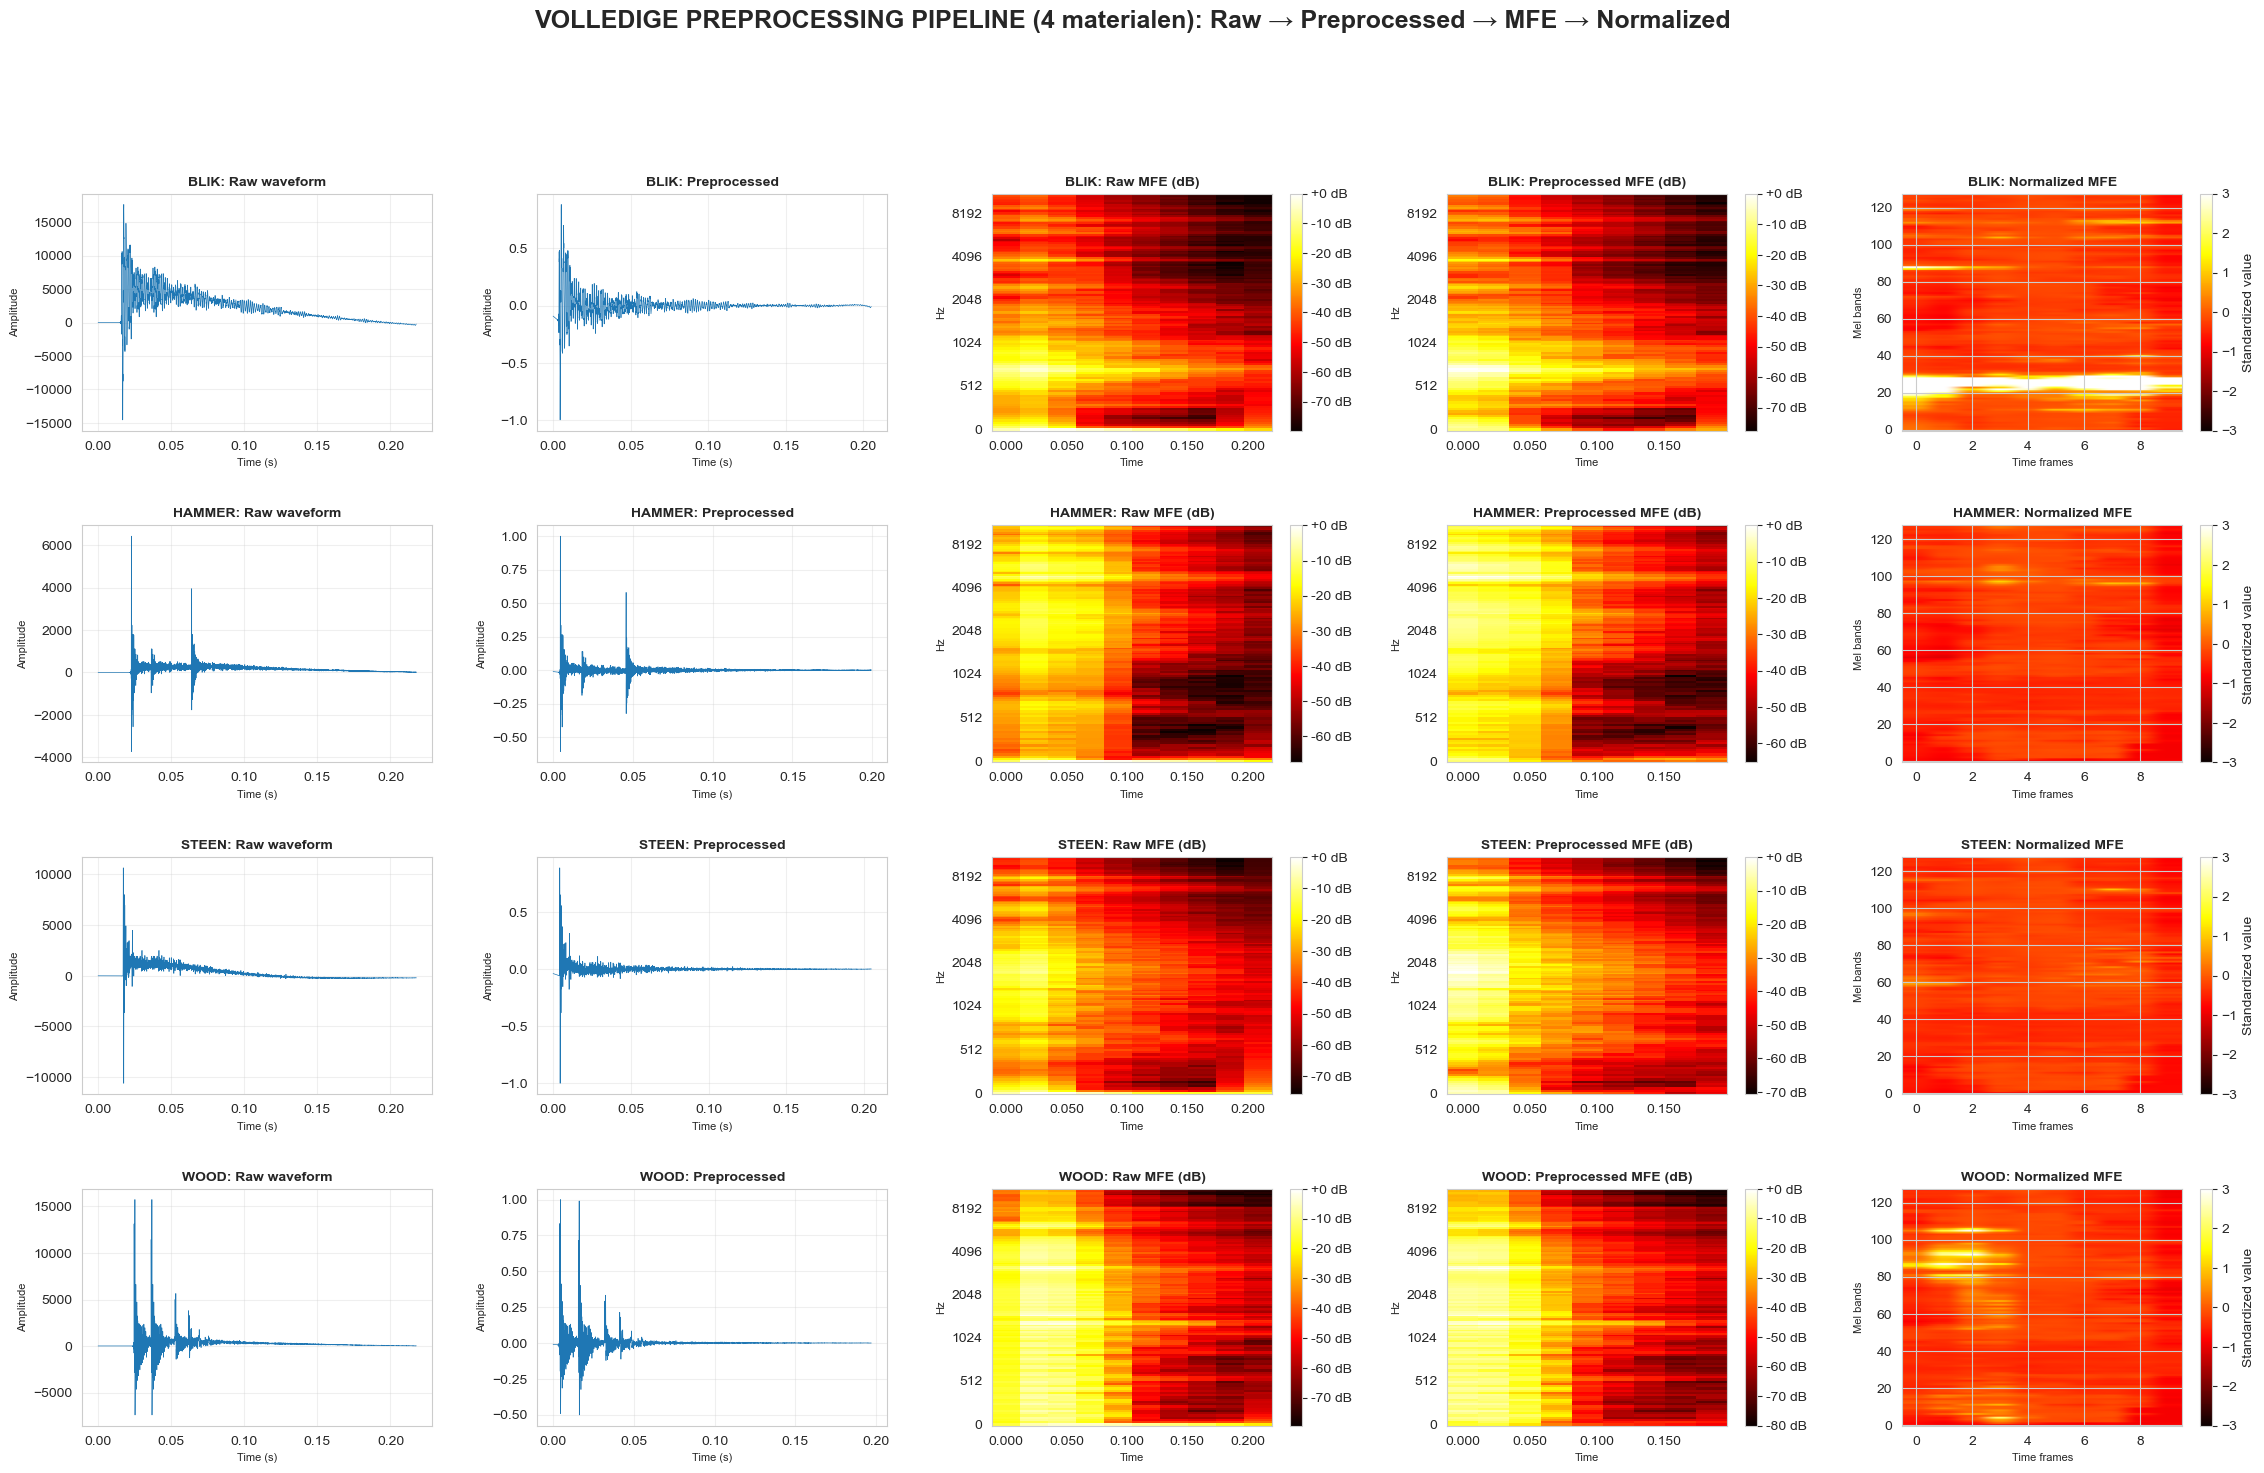

✓ Visualisatie voltooid voor alle materialen!

🎉 VOLLEDIGE PIPELINE SUCCESVOL UITGEVOERD!
📁 Data folder: Data/
📁 Processed folder: processed/
📁 Normalized folder: normalized/
📊 Aantal materialen verwerkt: 4



In [75]:
print(f"\n{'='*60}")
print("STAP 3: VISUALISATIE VAN PREPROCESSING PIPELINE")
print(f"{'='*60}")

# Vind alle materialen in Data folder (DYNAMISCH)
available_materials = [f.stem for f in DATA_DIR.glob("*.csv")]
print(f"\nBeschikbare materialen voor visualisatie: {available_materials}")

if len(available_materials) == 0:
    print("⚠️  Geen materialen gevonden voor visualisatie!")
else:
    # Maak visualisatie voor alle materialen
    n_materials = len(available_materials)
    
    fig = plt.figure(figsize=(28, 4 * n_materials))
    gs = fig.add_gridspec(n_materials, 5, hspace=0.4, wspace=0.3)
    
    for idx, material in enumerate(available_materials):
        print(f"Visualiseren: {material}...")
        
        # Laad eerste hit
        df_raw = pd.read_csv(DATA_DIR / f"{material}.csv")
        signal = df_raw.iloc[0].values.astype(np.float32)
        
        # Preprocess signaal
        preprocessed = preprocess_signal(signal)
        mfe = extract_mfe_features(signal)
        mfe_preprocessed = extract_mfe_features(preprocessed)
        
        # Laad normalized MFE
        df_normalized = pd.read_csv(NORMALIZED_DIR / f"{material}.csv")
        mfe_normalized = df_normalized.iloc[0].values.reshape(N_MELS, -1)
        
        # Plot 1: Raw waveform
        ax1 = fig.add_subplot(gs[idx, 0])
        time_raw = np.arange(len(signal)) / SR
        ax1.plot(time_raw, signal, linewidth=0.5, color='#1f77b4')
        ax1.set_title(f'{material.upper()}: Raw waveform', fontweight='bold', fontsize=10)
        ax1.set_xlabel('Time (s)', fontsize=8)
        ax1.set_ylabel('Amplitude', fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Preprocessed waveform
        ax2 = fig.add_subplot(gs[idx, 1])
        time_prep = np.arange(len(preprocessed)) / SR
        ax2.plot(time_prep, preprocessed, linewidth=0.5, color='#1f77b4')
        ax2.set_title(f'{material.upper()}: Preprocessed', fontweight='bold', fontsize=10)
        ax2.set_xlabel('Time (s)', fontsize=8)
        ax2.set_ylabel('Amplitude', fontsize=8)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Raw MFE (dB)
        ax3 = fig.add_subplot(gs[idx, 2])
        img3 = librosa.display.specshow(librosa.power_to_db(mfe, ref=np.max),
                                         x_axis='time', y_axis='mel',
                                         sr=SR, hop_length=HOP_LENGTH,
                                         ax=ax3, cmap='hot')
        ax3.set_title(f'{material.upper()}: Raw MFE (dB)', fontweight='bold', fontsize=10)
        ax3.set_xlabel('Time', fontsize=8)
        ax3.set_ylabel('Hz', fontsize=8)
        plt.colorbar(img3, ax=ax3, format='%+2.0f dB')
        
        # Plot 4: Preprocessed MFE (dB)
        ax4 = fig.add_subplot(gs[idx, 3])
        img4 = librosa.display.specshow(librosa.power_to_db(mfe_preprocessed, ref=np.max),
                                         x_axis='time', y_axis='mel',
                                         sr=SR, hop_length=HOP_LENGTH,
                                         ax=ax4, cmap='hot')
        ax4.set_title(f'{material.upper()}: Preprocessed MFE (dB)', fontweight='bold', fontsize=10)
        ax4.set_xlabel('Time', fontsize=8)
        ax4.set_ylabel('Hz', fontsize=8)
        plt.colorbar(img4, ax=ax4, format='%+2.0f dB')
        
        # Plot 5: Normalized MFE (standardized)
        ax5 = fig.add_subplot(gs[idx, 4])
        img5 = ax5.imshow(mfe_normalized, aspect='auto', origin='lower', cmap='hot',
                          vmin=-3, vmax=3)  # Typisch bereik voor standardized data
        ax5.set_title(f'{material.upper()}: Normalized MFE', fontweight='bold', fontsize=10)
        ax5.set_xlabel('Time frames', fontsize=8)
        ax5.set_ylabel('Mel bands', fontsize=8)
        plt.colorbar(img5, ax=ax5, label='Standardized value')
    
    fig.suptitle(f'VOLLEDIGE PREPROCESSING PIPELINE ({n_materials} materialen): Raw → Preprocessed → MFE → Normalized', 
                 fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualisatie voltooid voor alle materialen!")

print(f"\n{'='*60}")
print("🎉 VOLLEDIGE PIPELINE SUCCESVOL UITGEVOERD!")
print(f"{'='*60}")
print(f"📁 Data folder: {DATA_DIR}/")
print(f"📁 Processed folder: {PROCESSED_DIR}/")
print(f"📁 Normalized folder: {NORMALIZED_DIR}/")
print(f"📊 Aantal materialen verwerkt: {len(available_materials)}")
print(f"{'='*60}\n")